In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import streaming_classifier





In [2]:
# Load in all training data


waves, labels, samprate = load_training_data(path = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Datasets/Good Data - Sandeep no errors/",
                       scale_factor= 512/(2**13 - 1),
                       blacklist = ["blink", "different", "fast", "slow", "eyebrow"])



dict_keys(['left-middle-right-middle', 'left-middle', 'left-middle-right-steph', 'right-middle', 'left-middle-right-steph2', 'left-middle-right-middle#2']) dict_keys(['left-middle-right-middle', 'left-middle', 'left-middle-right-steph', 'right-middle', 'left-middle-right-steph2', 'left-middle-right-middle#2'])


/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Classifier/load_data.py:68: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


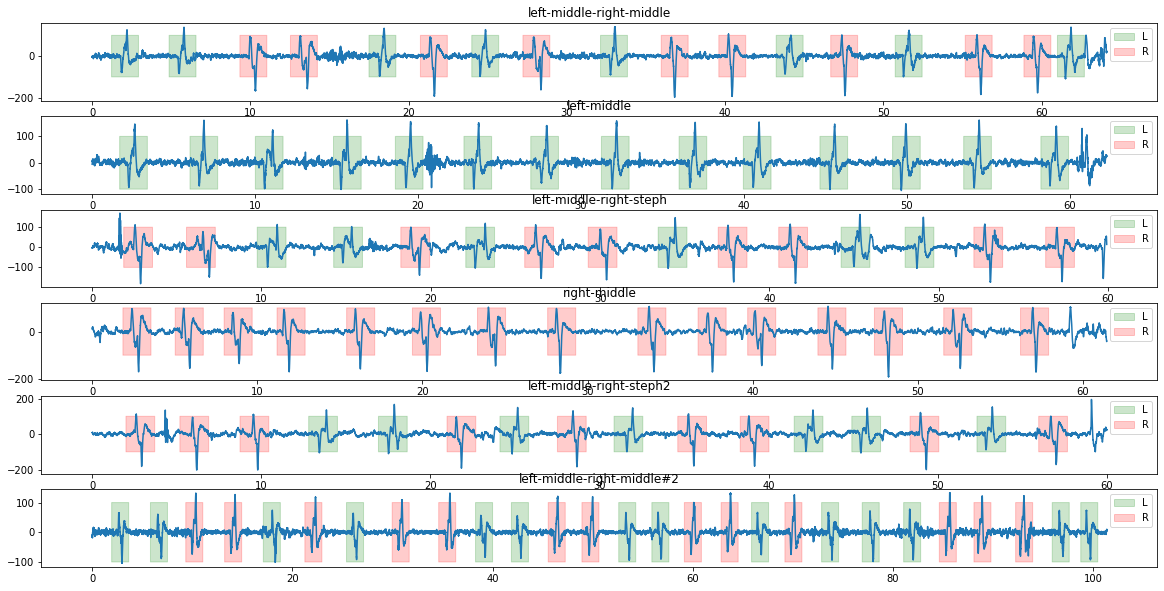

In [3]:
fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches((20, 10))

i=0
for key in waves.keys():
    
    wav_array = waves[key]
    labels_dat = labels[key]
    
    plot_labelled_wave(wav_array,samprate, labels_dat, ax, i, title=key)
    
    i+=1
    


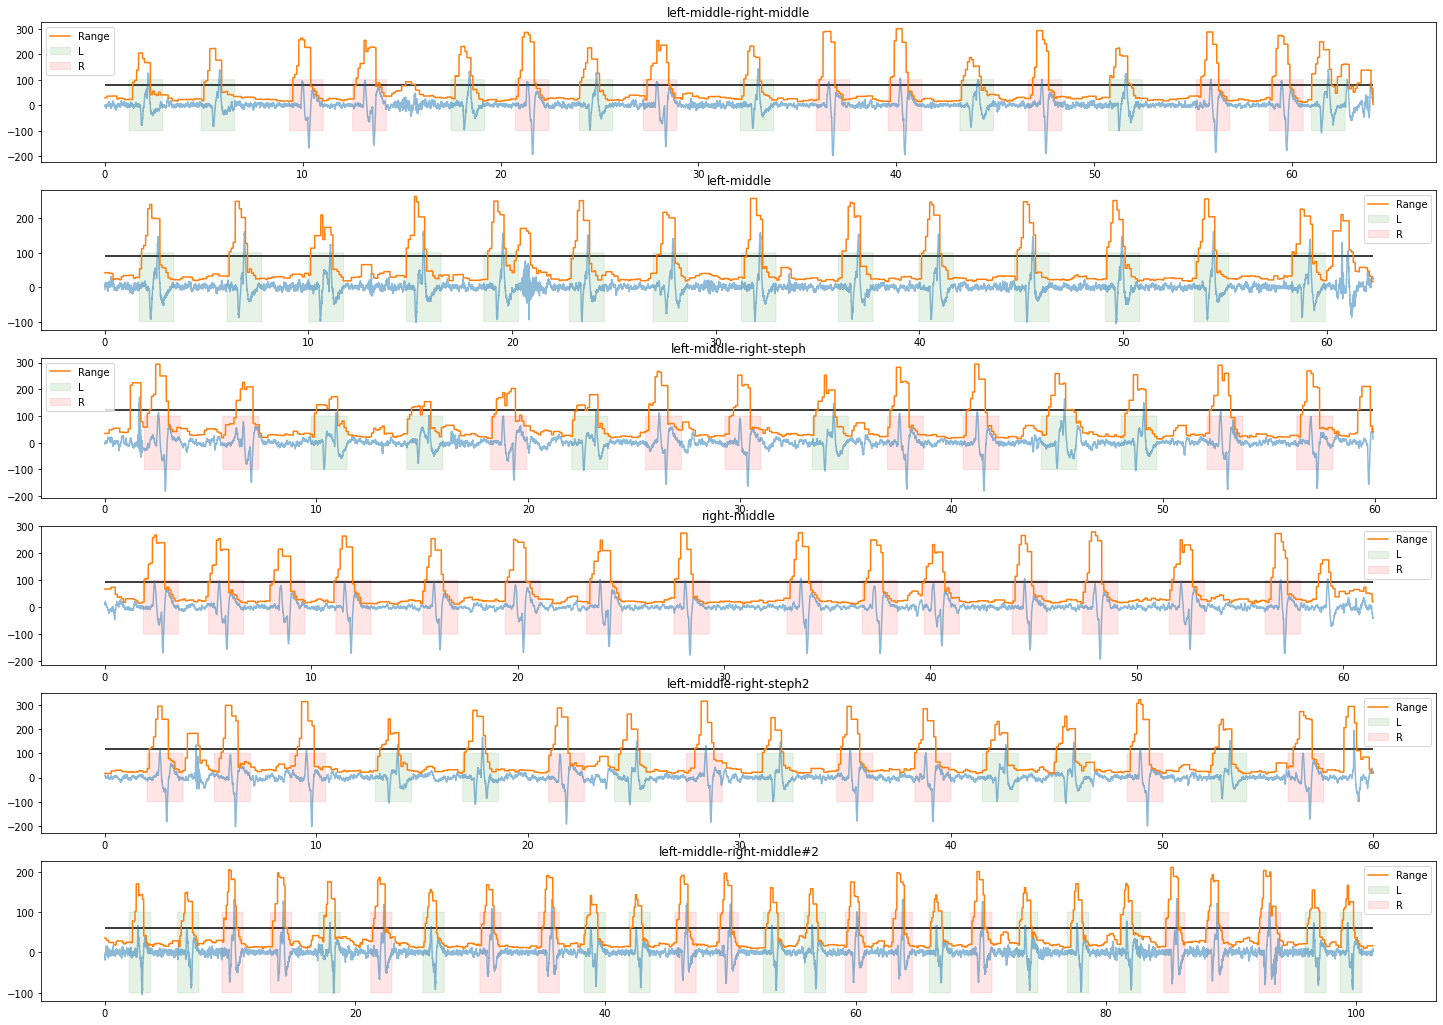

In [5]:

### Smart Thresholding ###
st_window = 10 # Seconds
st_scale = 0.35

st_window_ind = st_window*samprate




fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches((25, 3*len(waves)))



i=0
for key in waves.keys():
    
    wav_array = waves[key]
    labels_dat = labels[key]
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    
    plot_labelled_wave(wav_array, samprate, labels_dat, ax, i, title=key, wave_alpha=0.5, shade_alpha=0.1)

    
    
    index = 0
    step = int(0.1*samprate)
    window = int(0.5*samprate)
    test_stat_absmax = np.array([None]*len(wav_array))
    test_stat_zerocrossings = np.array([None]*len(wav_array))
    test_stat_max_change = np.array([None]*len(wav_array))
    test_stat_range = np.array([None]*len(wav_array))
    test_stat_sd = np.array([None]*len(wav_array))

    while index + 1 < len(wav_array):
        subset = wav_array[index:(index+window)]

#         test_stat_absmax[index:index+step] = np.max(np.abs(subset))
#         test_stat_zerocrossings[index:index+step] = np.sum(subset[0:-1] * subset[1::] <= 0)
#         test_stat_max_change[index:index+step] = np.max(np.abs(np.diff(subset)))
        test_stat_range[index:index+step] = np.max(subset) - np.min(subset)
        
#         test_stat_sd[index:index+step] = np.std(subset)
        index += step

#     ax[i].plot(time_seq, test_stat_absmax, label="max(abs(x))")
#     ax[i].plot(time_seq, test_stat_zerocrossings, label="zero_crossings")
#     ax[i].plot(time_seq, test_stat_max_change*100, label="max change")
    ax[i].plot(time_seq, test_stat_range, label="Range")
#     ax[i].plot(time_seq, test_stat_sd, label="SD")
    
    
    ## Smart threshold
    st_subset = wav_array[0:st_window_ind]
    st_range = np.max(st_subset) - np.min(st_subset)
    st_threshold = st_range*st_scale
    
    ax[i].hlines(st_threshold, time_seq[0], time_seq[-1], )
    ax[i].legend()
    
    i+=1





File:  left-middle-right-middle
False negative triggers: 0 []
False positive triggers: 2 [(14.6, 16.1), (62.1, 63.6)]
File:  left-middle
False negative triggers: 0 []
False positive triggers: 3 [(12.4, 13.9), (19.9, 21.4), (60.1, 61.6)]
File:  left-middle-right-steph
False negative triggers: 0 []
False positive triggers: 1 [(1.8, 3.3)]
File:  right-middle
False negative triggers: 0 []
False positive triggers: 1 [(58.5, 60.0)]
File:  left-middle-right-steph2
False negative triggers: 0 []
False positive triggers: 2 [(5.3, 6.8), (24.1, 25.6)]
File:  left-middle-right-middle#2
False negative triggers: 0 []
False positive triggers: 2 [(72.9, 74.4), (81.0, 82.5)]


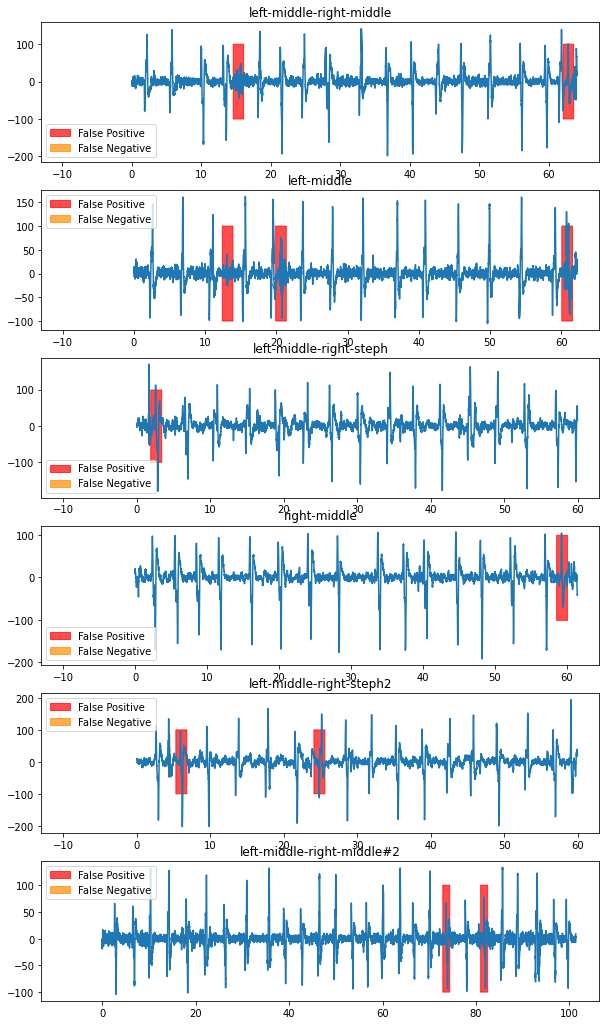

In [14]:
from copy import deepcopy


### Smart Thresholding ###
st_window = 10 # Seconds
st_scale = 0.5


# %matplotlib notebook

before_buffer = 0.7
after_buffer = 1


fig, ax = plt.subplots(len(waves), 1)
fig.set_size_inches(10, 3*len(waves))





i=0
for key in waves.keys():
    
    predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                                                                    waves[key],
                                                                    samprate,
                                                                    window_size = 1.5, # time plotted in window [s]
                                                                    N_loops_over_window = 15, # implicitly defines buffer to be 1/x of the window
                                                                    total_time = None,  # max time
                                                                    hyp_detection_buffer_end = 0.3, # seconds - how much time to shave off either end of the window in order to define the middle portion
                                                                    hyp_detection_buffer_start = 0.7,
                                                                    hyp_event_smart_threshold_window = st_window, 
                                                                    hyp_event_smart_threshold_factor = st_scale, 
                                                                    hyp_event_history = 5,
                                                                    hyp_consecutive_triggers = 3,
                                                                    hyp_consecutive_reset = 1,
                                                                    plot = False,
                                                                    store_events = True, 
                                                                    verbose=False,
                                                                    live = False)
        
    
#     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i, title=key, actual_alpha=0.2)
    
    
    actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
    actual_leftovers = deepcopy(actual_times)
    pred_leftovers = deepcopy(predictions_timestamps)
    
    
    for act_times in actual_times:
        for pred_times in predictions_timestamps:
            if act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and pred_times in pred_leftovers and act_times in actual_leftovers:
                actual_leftovers.remove(act_times)
                pred_leftovers.remove(pred_times)
                
                

    plot_detection_errors(waves[key], samprate, pred_leftovers, actual_leftovers, ax, i, title=key, alpha=0.7)
    ax[i].set_xlim(-13)

                
    print("File: ", key)
    print(f"False negative triggers: {len(actual_leftovers)}", actual_leftovers)
    print(f"False positive triggers: {len(pred_leftovers)}",  pred_leftovers)
    
    
    i+=1
